## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.data.make_dataset import TCGA_LUAD
tgca_luad = TCGA_LUAD()
# tgca_luad.gene_univariate_feature_selection(alpha=0.001)

mirna_tumor (506, 1883)
mirna_normal (46, 1883)
gene_tumor (515, 20486)
gene_normal (59, 20486)


## Build all miRNA-gene associations

In [3]:
all_mirna_gene_assc = []
for m in tgca_luad.mirna_list:
    for t in tgca_luad.gene_symbols:
        all_mirna_gene_assc.append((m, t))
print len(all_mirna_gene_assc)
all_mirna_gene_assc = pandas.DataFrame(all_mirna_gene_assc, columns=["MiRBase ID", "Gene Symbol"])
print all_mirna_gene_assc.shape

KeyboardInterrupt: 

## Loading TargetScan database for predicted miRNA-targets interactions

In [4]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(tgca_luad.mirna_list) & targetScan_df['Gene Symbol'].isin(tgca_luad.gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Loading miRanda database for predicted miRNA-targets interactions

In [5]:
miRanda_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/miRanda_hg19_predictions_S_C_aug2010.txt'), delimiter='\t')
miRanda_df = miRanda_df[['mirna_name',  'gene_symbol']]

miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.lower()
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("*", "")
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("-3p.*|-5p.*", "")
print miRanda_df.shape

miRanda_df.columns = ["MiRBase ID", "Gene Symbol"]
miRanda_df = miRanda_df[miRanda_df['MiRBase ID'].isin(tgca_luad.mirna_list) & miRanda_df['Gene Symbol'].isin(tgca_luad.gene_symbols)].dropna().drop_duplicates()
print miRanda_df.shape
putative_assocs = pandas.concat([targetScan_df, miRanda_df]).dropna().drop_duplicates()
print putative_assocs.shape

(1097064, 2)


(544648, 2)


(640757, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs
## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target

In [6]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(miRNAs=tgca_luad.mirna_list, targets=tgca_luad.gene_symbols)

network.fit(tag="normal-StgI", p_threshold=0.001, n_jobs=7,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='normal',
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='normal',
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 20
n_B 275


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


7641

In [7]:
network.fit(tag="StgI-StgII", p_threshold=0.001, n_jobs=7,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 275
n_B 120


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


6479

In [10]:
network.fit(tag="StgII-StgIII", p_threshold=0.001, n_jobs=7,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 120
n_B 84


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


5988

In [11]:
network.fit(tag="StgIII-StgIV", p_threshold=0.001, n_jobs=7,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 84
n_B 24


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


<string>:52: RuntimeWarning: invalid value encountered in double_scalars


<string>:55: RuntimeWarning: invalid value encountered in double_scalars


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


src/models/miRNA_target_network.py:100: RuntimeWarning: invalid value encountered in log
  z_B = (np.log(r_B_plus) - np.log(r_B_minus)) / 2.0


src/models/miRNA_target_network.py:99: RuntimeWarning: invalid value encountered in log
  z_A = (np.log(r_A_plus) - np.log(r_A_minus)) / 2.0


11506

In [13]:
network.build_miRNA_features()

miRNAs_in_MTDN 274
normal_stgI_genes 3320
stgI_StgII_genes 2909
stgII_StgIII_genes 3335
stgIII_StgIV_genes 3955

1881


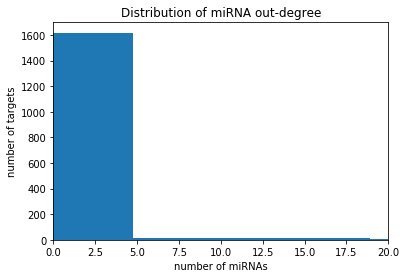

In [14]:
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite'] == 0)
targets_nodes = set(network.B) - miRNAs_nodes

miRNA_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)[1]
print len(miRNA_nodes_degrees)

plt.figure()
plt.hist(miRNA_nodes_degrees.values(), bins=100)
plt.title('Distribution of miRNA out-degree')
plt.xlim((0,20))
plt.ylabel('number of targets')
plt.xlabel('number of miRNAs')
plt.show()

20484


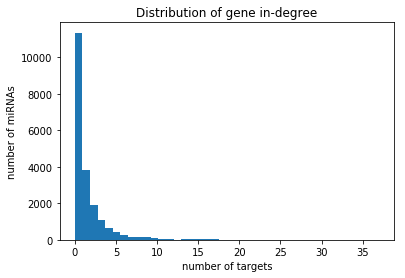

In [15]:
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)[1]
print len(targets_nodes_degrees)

plt.figure()
plt.hist(targets_nodes_degrees.values(), bins=40)
plt.title('Distribution of gene in-degree')
plt.ylabel('number of miRNAs')
plt.xlabel('number of targets')
plt.show()

[253, 10, 7, 3, 1]


[253, 10, 3, 3, 3, 1, 1]


[249, 10, 3, 3, 2, 2, 2, 1, 1, 1]


[249, 10, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1]


[244, 10, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]


[244, 8, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[240, 8, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


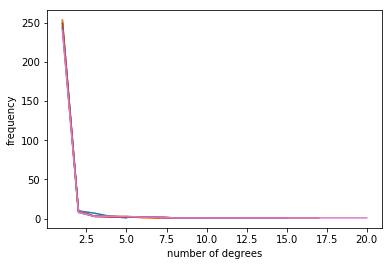

In [16]:
n_clusters = [5, 7, 10, 12, 15, 17, 20]

plt.figure()
for n_cluster in n_clusters:
    bin_count = network.run_miRNA_clustering(n_cluster=n_cluster, linkage='complete')
    print sorted(bin_count, reverse=True)
    plt.plot(range(1, len(bin_count)+1), sorted(bin_count, reverse=True))
plt.ylabel('frequency')
plt.xlabel('number of degrees')
plt.show()

In [17]:
network.run_miRNA_clustering(n_cluster=10, linkage='complete')

array([  3, 249,   2,  10,   3,   1,   1,   2,   1,   2])

## TarBase: Validated miRNA-target interactions

In [257]:
TarBase_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TarBase_Experiment_Valid_miRNA-Targets.csv'), delimiter='\t')
TarBase_df = TarBase_df[TarBase_df['species'] == 'Homo sapiens']
TarBase_df = TarBase_df[TarBase_df['tissue'].isin(['Lung Cancerous Tissues', 'Lung'])]
TarBase_df = TarBase_df[TarBase_df['category'] == 'Cancer/Malignant']
TarBase_df['mirna'] = TarBase_df['mirna'].str.lower()
TarBase_df['mirna'] = TarBase_df['mirna'].str.replace("-3p.*|-5p.*", "")
TarBase_df.drop_duplicates(inplace=True)

TarBase_df = TarBase_df[['geneName', 'mirna']]
TarBase_df.columns = ["Gene Symbol", "MiRBase ID"]
# TarBase_df

In [259]:
for row in TarBase_df.iterrows():
    if network.B.get_edge_data(row[1]['MiRBase ID'], row[1]['Gene Symbol']):
        print row[1]['mirna'], row[1]['Gene Symbol'], network.B.get_edge_data(row[1]['MiRBase ID'], row[1]['Gene Symbol'])

### Prepare samples for Classification task

In [24]:
from sklearn.model_selection import train_test_split

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=True, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
                              label_mapping={'normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})

X_multi, y_multi = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False, normalize=False,
                                          pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                                          label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = \
    train_test_split(X_multi, y_multi, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y_multi)

print "X", X.shape
print "y", y.shape

print y.value_counts()
print y_multi.value_counts()

X (92, 1881)
y (92,)
normal       46
Stage I      29
Stage II     11
Stage III     6
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
normal        46
Stage IV      24
Name: pathologic_stage, dtype: int64


## Create Classifiers

In [19]:
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 1000,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5

X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])
X_multi_train = np.asfortranarray(X_multi_train, dtype=myfloat)
Y_multi_train = np.asfortranarray(Y_multi_train, dtype=myfloat)
Y_multi_train = np.reshape(Y_multi_train, [Y_multi_train.shape[0], 1])

# L1 Lasso
l1_lasso_param = param.copy()
l1_lasso_param['loss'] = 'weighted-logistic'
l1_lasso_param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=l1_lasso_param)

# Group Lasso L2
# group_l2_param = param.copy()
# group_l2_param['loss'] = 'weighted-logistic'
# group_l2_param['regul'] = 'group-lasso-l2'
# group_l2 = SPAMSClassifier()
# group_l2.fit(X_train, Y_train, groups=network.get_miRNA_cluster_assgn(), params=group_l2_param)

# Elastic Net
elastic_net_param = param.copy()
elastic_net_param['loss'] = 'weighted-logistic'
elastic_net_param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=elastic_net_param)

# Sparse Group Lasso
sparse_group_l2_param = param.copy()
sparse_group_l2_param['loss'] = 'logistic'
sparse_group_l2_param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2_param['lambda1'] = 0.2
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(), params=sparse_group_l2_param)

# Multi Logistic
multi_task_l1l2_param = param.copy()
multi_task_l1l2_param['loss'] = 'multi-logistic'
multi_task_l1l2_param['regul'] = 'l1l2'
multi_task_l1l2_param['max_it'] = 200
multi_task_l1l2_param['lambda1'] = 0.5
multi_task_l1l2 = SPAMSClassifier()
multi_task_l1l2.fit(X_multi_train, Y_multi_train, groups=None, params=multi_task_l1l2_param)

/opt/anaconda/lib/python2.7/site-packages/parsimony/config.py:51: RuntimeWarning: Could not locate the config file.
  warnings.warn("Could not locate the config file.", RuntimeWarning)


ValueError: could not convert string to float: normal

## Logistic Regression with L1L2 & Overlapping Group LASSO regularizer

In [25]:
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.gl as gl
import parsimony.utils.start_vectors as start_vectors


X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=True, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
                              label_mapping={'normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

A = gl.linear_operator_from_groups(X_train.shape[1],
                                   network.miRNA_clusters_int
                                   # weights=[2*1./len(g) for g in network.miRNA_groups_int]
                                   )
beta = start_vectors.ZerosStartVector().get_vector(X_train.shape[1])

logistic_L1L2GL = estimators.LogisticRegressionL1L2GL(l1=2.5, l2=0.0, gl=3.5, A=A,
                                                      algorithm=algorithms.proximal.FISTA(),
                                                      class_weight='auto',
                                                      algorithm_params=dict(max_iter=1000),
                                                      mean=False)
logistic_L1L2GL.fit(X=X_train, y=Y_train, beta=beta)

print 'Non-zero:', len(logistic_L1L2GL.beta.nonzero()[0])

ValueError: Multinomial classification with more than 2 labels is not possible

## OneVsRestClassifier

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from src.models.group_lasso_spams import LRSGLWrapper

lrsgl_one_vs_rest = OneVsRestClassifier(LRSGLWrapper(l1=2.5, l2=0.0, gl=5, A=A, max_iter=500))
lrsgl_one_vs_rest.fit(X=X_multi_train, y=Y_multi_train)

lr_one_vs_rest = OneVsRestClassifier(LRSGLWrapper(l1=2.5, l2=0.0, gl=0, max_iter=1000))
lr_one_vs_rest.fit(X=X_multi_train, y=Y_multi_train)

OneVsRestClassifier(estimator=LRSGLWrapper(A=None, gl=0, l1=2.5, l2=0.0, max_iter=1000),
          n_jobs=1)

## ROC Curve Cross Validation for LRSGL

ROC micro nan
ROC macro nan


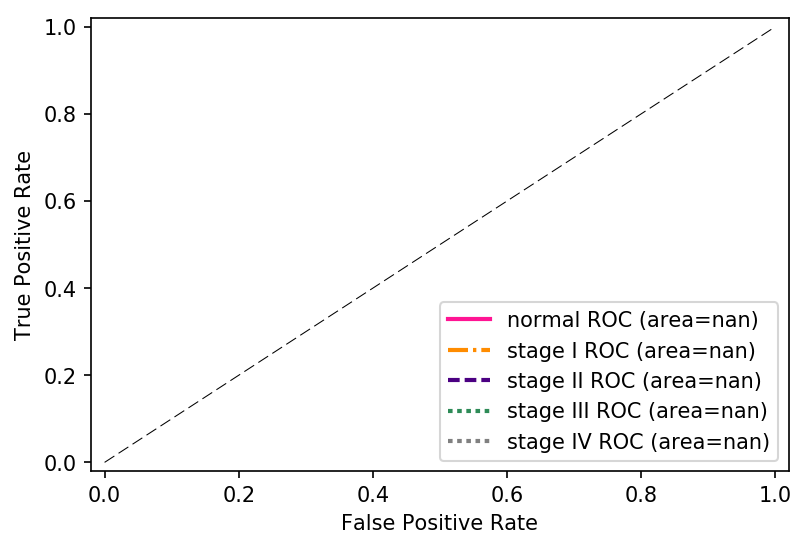

In [26]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                              label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]
n_samples, n_features = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y,
                                                    random_state=0)

colors = cycle(['darkorange', 'indigo', 'seagreen', 'gray', 'red', 'cyan'])
linestyles = cycle(['solid', 'dashed', 'dashdot', 'dotted'])
lw = 2

lr_ovr_with_sgl = OneVsRestClassifier(LRSGLWrapper(l1=2.5, l2=0.0, gl=3.5, A=A, max_iter=1000))
y_score = lr_ovr_with_sgl.fit(X_train, y_train).predict_proba(X_test)

j = 0

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(dpi=150)
print 'ROC micro', roc_auc["micro"]
print 'ROC macro', roc_auc["macro"]

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cycle(['deeppink', 'darkorange', 'indigo', 'seagreen', 'gray', 'red', 'cyan'])
linestyles = cycle(['solid', 'dashdot', '--', 'dotted', ':'])
for i, color, linestyle in zip(range(n_classes), colors, linestyles):
    if i == 0:
        label = 'normal'
    elif i==1:
        label = 'stage I'
    elif i==2:
        label = 'stage II'
    elif i==3:
        label = 'stage III'
    elif i==4:
        label = 'stage IV'
        
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle=linestyle,
             label='{0} ROC (area={1:0.2f})'
             ''.format(label, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Cross Validation for LR WITHOUT SGL

ROC micro nan
ROC macro nan


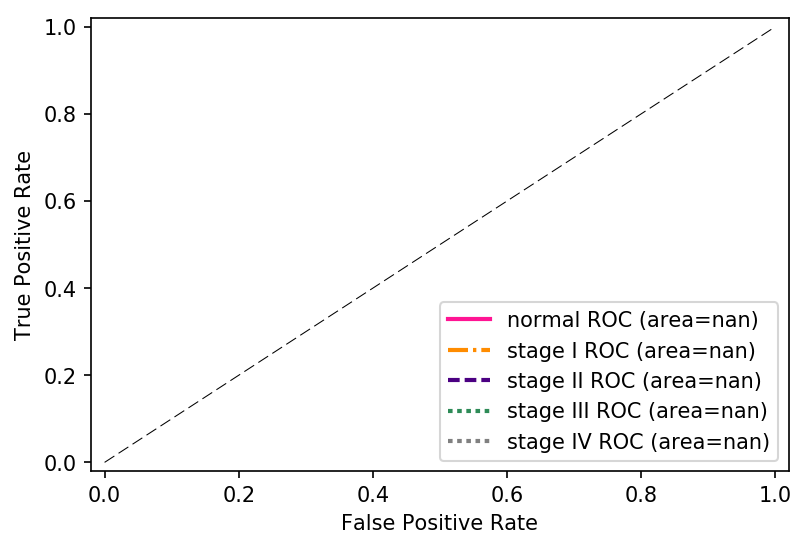

In [27]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                              label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]
n_samples, n_features = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y,
                                                    random_state=2)
lw = 2

lr_ovr_wo_sgl = OneVsRestClassifier(LRSGLWrapper(l1=5.5, max_iter=1000))
y_score = lr_ovr_wo_sgl.fit(X_train, y_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(dpi=150)

print 'ROC micro', roc_auc["micro"]
print 'ROC macro', roc_auc["macro"]

colors = cycle(['deeppink', 'darkorange', 'indigo', 'seagreen', 'gray', 'red', 'cyan'])
linestyles = cycle(['solid', 'dashdot', '--', 'dotted', ':'])
for i, color, linestyle in zip(range(n_classes), colors, linestyles):
    if i == 0:
        label = 'normal'
    elif i==1:
        label = 'stage I'
    elif i==2:
        label = 'stage II'
    elif i==3:
        label = 'stage III'
    elif i==4:
        label = 'stage IV'
        
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle=linestyle,
             label='{0} ROC (area={1:0.2f})'
             ''.format(label, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Parameter selection

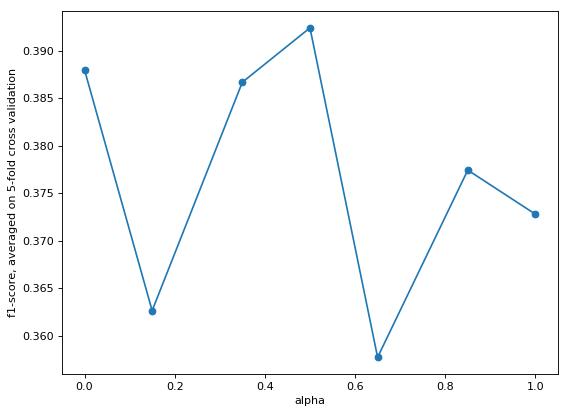

In [181]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(parameters['alpha'], l1_scores, 'o-')

plt.xlabel('alpha')
plt.ylabel('f1-score, averaged on 5-fold cross validation')
plt.title('')
# plt.ylim(0, 1)
plt.show()

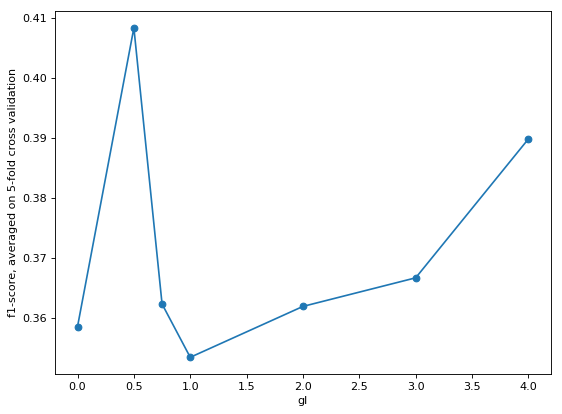

In [115]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(parameters['lambda'], gl_scores, 'o-')

plt.xlabel('gl')
plt.ylabel('f1-score, averaged on 5-fold cross validation')
plt.title('')
# plt.ylim(0,1)
plt.show()


## Classification Report

In [298]:
from sklearn import metrics

for model, name in [
                    # (logistic_L1L2GL, 'Logistic L1L2GL'),
                    (lr_ovr_wo_sgl, 'lr_ovr_wo_sgl'),
                    (lr_ovr_with_sgl, 'lr_ovr_with_sgl'),
                    # (multi_task_l1l2, 'multi-task l1l2'),
                    # (multi_task_l1l2_cluster, 'multi_task_l1l2_cluster'),
                    # (group_l2, 'group_small'),
                    # (l1_lasso, 'l1_lasso'),
                    # (elastic_net, 'elastic_net'),
                    # (sparse_group_l2, 'sparse-group_small')
                    ]:
    print '\n', name
    if model is logistic_L1L2GL:
        predicted = logistic_L1L2GL.predict(X_train)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_train, predicted)
        predicted = logistic_L1L2GL.predict(X_test)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_test, predicted)
    elif model is multi_task_l1l2 or model is lr_ovr_wo_sgl or model is lr_ovr_with_sgl:
        print metrics.classification_report(Y_multi_train, model.predict(X_multi_train))
        print metrics.classification_report(Y_multi_test, model.predict(X_multi_test))
    # elif model is multi_task_l1l2_cluster:
    #     print metrics.classification_report(Y_multi_train, model.predict(X_multi_train.T[clustered_miRNA_indices].T))
        # print metrics.classification_report(Y_multi_test, model.predict(X_multi_test.T[clustered_miRNA_indices].T))
    else:
        print metrics.classification_report(Y_train, model.predict(X_train))
        print metrics.classification_report(Y_test, model.predict(X_test))


lr_ovr_wo_sgl


ValueError: row index exceeds matrix dimensions

## Loading HMDD database for experimentally validated NSCLC miRNA

In [278]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()
print "HMDD_lung_neoplasm_miRNAs", HMDD_lung_neoplasm_miRNAs.shape

miRCancer_luad_miRNA_df = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(miRCancer_luad_miRNA_df['miRNA'].tolist())
print "miRCancer_luad_miRNAs", len(miRCancer_luad_miRNAs)


mir2disease_nsclc_miRNA_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/mir2Disease_miRNA-Disease.txt'), delimiter='\t', header=-1) 
mir2disease_nsclc_miRNA_df.columns = ['miRNA', 'disease', 'up_down', 'method', 'year', 'description'] 
mir2disease_nsclc_miRNA_df = mir2disease_nsclc_miRNA_df[(mir2disease_nsclc_miRNA_df['disease'] == 'non-small cell lung cancer (NSCLC)')]
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.lower()
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("*", "")
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("-3p.*|-5p.*", "")
mir2disease_nsclc_miRNA_df.drop_duplicates(inplace=True)
mir2disease_nsclc_miRNAs = mir2disease_nsclc_miRNA_df['miRNA'].unique()
print "mir2disease_nsclc_miRNAs", mir2disease_nsclc_miRNAs.shape

dbDEMC_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/dbDEMC.txt'), delimiter='\t')
dbDEMC_df = dbDEMC_df[dbDEMC_df['Cancer Type'] == 'lung cancer']
dbDEMC_df = dbDEMC_df[dbDEMC_df['Cancer Subtype'] == 'lung adenocarcinoma']
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.lower()
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.replace("*", "")
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.replace("-3p.*|-5p.*", "")
dbDEMC_luad_miRNAs = dbDEMC_df['miRNA ID'].unique()
print 'dbDEMC_luad_miRNAs', len(dbDEMC_df['miRNA ID'].unique())

validating_miRNAs = dbDEMC_luad_miRNAs

HMDD_lung_neoplasm_miRNAs (157,)
miRCancer_luad_miRNAs 27
mir2disease_nsclc_miRNAs (24,)


dbDEMC_luad_miRNAs 545


## Compare models by recall rate

In [299]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate, get_miRNA_names
from src.models.group_lasso_spams import LRSGLWrapper

models = []
for model, name in [
                    (lr_ovr_with_sgl, 'lr_ovr_with_sgl'),
                    (lr_ovr_wo_sgl, 'lr_ovr_wo_sgl')
                    # (logistic_L1L2GL, 'Logistic L1L2GL'),
                    # (multi_task_l1l2, 'multi-task l1l2'),
                    # (multi_task_l1l2_cluster, 'multi_task_l1l2_cluster'),
                    # (group_l2, 'group_small'),
                    # (l1_lasso, 'l1_lasso'),
                    # (elastic_net, 'elastic_net'),
                    # (sparse_group_l2, 'sparse-group_small')
                    ]:
    if model is logistic_L1L2GL:
        models.append([name,
                   len(model.beta.nonzero()[0]),
                   recall_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:275], tgca_luad.mirna_list),
                               validated_miRNAs=validating_miRNAs),
                    (lr_ovr_with_sgl, 'lr_ovr_with_sgl'),
                    (lr_ovr_wo_sgl, 'lr_ovr_wo_sgl')
                    # (logistic_L1L2GL, 'Logistic L1L2GL'),
                    # (multi_task_l1l2, 'multi-task l1l2'),
                    # (multi_task_l1l2_cluster, 'multi_task_l1l2_cluster'),
                    # (group_l2, 'group_small'),
                    # (l1_lasso, 'l1_lasso'),
                    # (elastic_net, 'elastic_net'),
                    # (sparse_group_l2, 'sparse-group_small')
                    
                   precision_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:275], tgca_luad.mirna_list),
                                  validated_miRNAs=validating_miRNAs) ])
    elif model is lr_ovr_with_sgl:
        models.append([name,
                   LRSGLWrapper.get_selected_miRNAs(lr_ovr_with_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=LRSGLWrapper.get_selected_miRNAs(lr_ovr_with_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=LRSGLWrapper.get_selected_miRNAs(lr_ovr_with_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])
    elif model is lr_ovr_wo_sgl:
        models.append([name,
                   LRSGLWrapper.get_selected_miRNAs(lr_ovr_wo_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=LRSGLWrapper.get_selected_miRNAs(lr_ovr_wo_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=LRSGLWrapper.get_selected_miRNAs(lr_ovr_wo_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])
    else:
        models.append([name,
                   model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])

pandas.DataFrame(models, columns=['method', 'no_selected', 'recall_rate', 'precision_rate']).sort_values(by='recall_rate', ascending=False)
# (group_l2_large_groups, 'group_l2_large_groups'),
# (l1_lasso, 'l1_lasso'),
# (elastic_net, 'elastic_net'),
# (sparse_group_l2, 'sparse-group-lasso-l2'),
# (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')

,method,no_selected,recall_rate,precision_rate
0,lr_ovr_with_sgl,1023,0.715596,0.381232
1,lr_ovr_wo_sgl,731,0.673394,0.502052


## Check each candidate miRNA's if validated

In [38]:
candidate_miRNAs = multi_task_l1l2.get_selected_miRNAs(tgca_luad.mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in validating_miRNAs, axis=1)
# candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated
50,hsa-mir-148a,-0.000126,True
180,hsa-mir-451a,-0.000102,True
69,hsa-mir-182,-0.000089,True
160,hsa-mir-372,0.000086,False
27,hsa-mir-126,-0.000084,True
225,hsa-mir-582,0.000080,True
131,hsa-mir-30d,-0.000078,True
115,hsa-mir-25,-0.000078,True
92,hsa-mir-200a,-0.000078,True
44,hsa-mir-142,0.000076,True


In [157]:
candidate_miRNAs = pandas.DataFrame([(tgca_luad.mirna_list[m], logistic_L1L2GL.beta[m][0]) for m in logistic_L1L2GL.beta.nonzero()[0]])
candidate_miRNAs.columns = ['miRNA', 'coef']
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in validating_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(20)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,miRNA,coef,validated,groups
87,hsa-mir-203a,0.000195,True,[]
64,hsa-mir-182,0.000082,True,[]
48,hsa-mir-148a,0.000081,True,[]
15,hsa-mir-103a-2,-0.000070,True,[]
14,hsa-mir-103a-1,-0.000069,False,[]
90,hsa-mir-21,0.000065,True,[]
115,hsa-mir-29c,0.000061,True,[]
179,hsa-mir-99b,-0.000054,True,[]
122,hsa-mir-30e,0.000053,True,[]
65,hsa-mir-183,0.000050,True,[]


### Recall & Precision of Top Ranked miRNAs

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


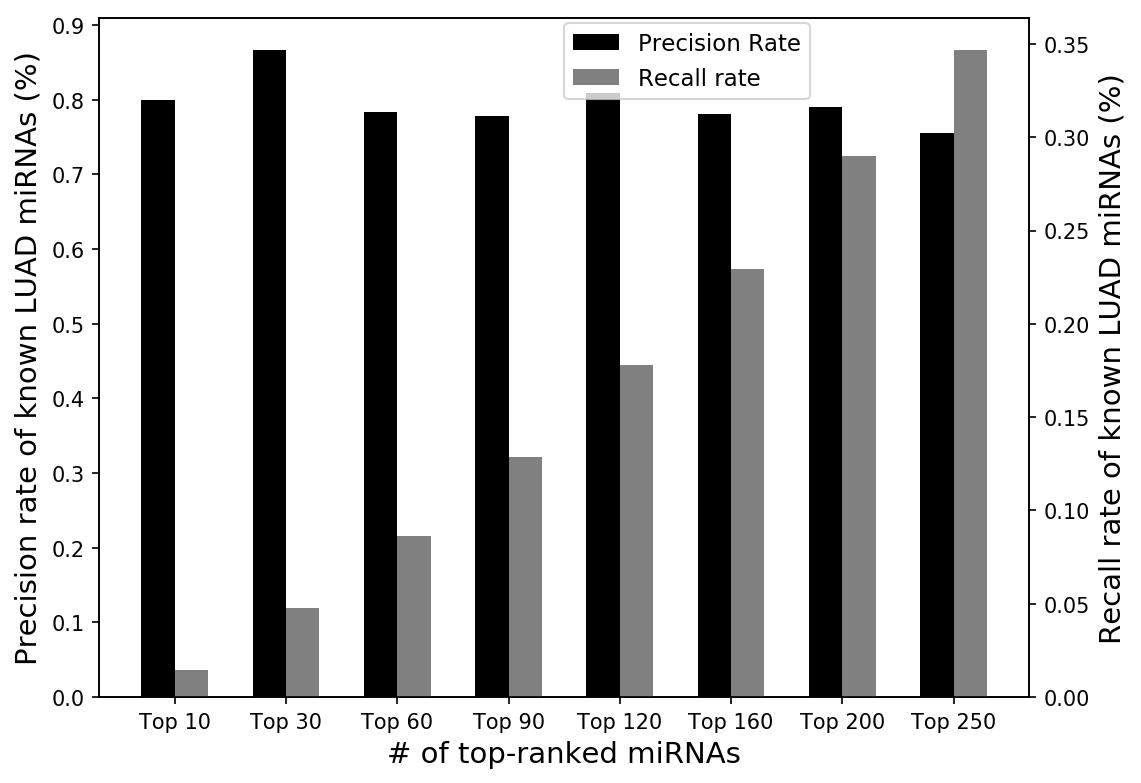

In [154]:
top_k_s = [10, 30, 60, 90, 120, 160, 200, 250]

candidate_miRNAs = pandas.DataFrame()
candidate_miRNAs['miRNAs'] = tgca_luad.mirna_list
candidate_miRNAs['coef'] = logistic_L1L2GL.beta

recall_rates = []
precision_rates = []
for top_k in top_k_s:
    top_k_miRNAs = candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(top_k)['miRNAs'].tolist()

    recall_rates.append(recall_rate(candidate_miRNAs=top_k_miRNAs, validated_miRNAs=dbDEMC_luad_miRNAs))
    precision_rates.append(precision_rate(candidate_miRNAs=top_k_miRNAs, validated_miRNAs=dbDEMC_luad_miRNAs))
    
# plt.figure()
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
width = 0.3
font_size = 14

rects1 = ax.bar(range(len(top_k_s)), precision_rates, width, color='black')
ax.set_ylabel('Precision rate of known LUAD miRNAs (%)', fontsize=font_size)
ax.set_yticks([i/10. for i in range(10)])
# ax.set_ylim((0, 1))

ax2 = ax.twinx()
rects2 = ax2.bar([width+k for k in range(len(top_k_s))], recall_rates, width, color='gray')
# ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Recall rate of known LUAD miRNAs (%)', fontsize=font_size)

ax.legend((rects1[0], rects2[0]), ('Precision Rate', 'Recall rate'), loc=(0.5, 0.88), fontsize=11)
ax.set_xlabel('# of top-ranked miRNAs', fontsize=font_size)
ax.set_xticks([width/2+k for k in range(len(top_k_s))])
ax.set_xticklabels(['Top '+str(top_k) for top_k in top_k_s], fontsize=10)
plt.show()

## Precision for each miRNA groups

In [292]:
miRNA_groups_precision = []
miRNA_groups_precision 
for cluster in network.miRNA_clusters_int:
    print get_miRNA_names(cluster, tgca_luad.mirna_list, miR_name=True) 
    miRNA_groups_precision.append((len(cluster), 
                                   get_miRNA_names(cluster, tgca_luad.mirna_list, miR_name=True),
                                   precision_rate(candidate_miRNAs=get_miRNA_names(cluster, tgca_luad.mirna_list), 
                                                  validated_miRNAs=dbDEMC_luad_miRNAs),
                                   len(set(get_miRNA_names(cluster, tgca_luad.mirna_list)).intersection(
                                       get_miRNA_names(logistic_L1L2GL.beta.nonzero()[0], tgca_luad.mirna_list))),
                                   precision_rate(candidate_miRNAs=set(get_miRNA_names(cluster, tgca_luad.mirna_list)).intersection(
                                       get_miRNA_names(logistic_L1L2GL.beta.nonzero()[0], tgca_luad.mirna_list)), 
                                                  validated_miRNAs=dbDEMC_luad_miRNAs)
                                   ))

pandas.DataFrame(miRNA_groups_precision, columns=['Size of cluster', 'miRNA', 'precision to LUAD', '# selected in model', 'selected in model and in LUAD']).sort_values(by='Size of cluster', ascending=False)

['mir-381', 'mir-410', 'mir-539']
['let-7b', 'let-7c', 'let-7d', 'let-7e', 'let-7g', 'let-7i', 'mir-100', 'mir-106a', 'mir-106b', 'mir-107', 'mir-10a', 'mir-10b', 'mir-1193', 'mir-1197', 'mir-122', 'mir-1224', 'mir-1251', 'mir-125a', 'mir-126', 'mir-127', 'mir-1271', 'mir-1297', 'mir-1298', 'mir-1306', 'mir-130a', 'mir-130b', 'mir-132', 'mir-133b', 'mir-134', 'mir-135b', 'mir-137', 'mir-139', 'mir-140', 'mir-141', 'mir-142', 'mir-143', 'mir-144', 'mir-145', 'mir-146a', 'mir-146b', 'mir-148a', 'mir-148b', 'mir-149', 'mir-150', 'mir-151a', 'mir-152', 'mir-154', 'mir-155', 'mir-15a', 'mir-15b', 'mir-17', 'mir-181c', 'mir-181d', 'mir-182', 'mir-183', 'mir-184', 'mir-185', 'mir-186', 'mir-187', 'mir-188', 'mir-18a', 'mir-18b', 'mir-190a', 'mir-190b', 'mir-191', 'mir-192', 'mir-193a', 'mir-193b', 'mir-195', 'mir-196b', 'mir-197', 'mir-199b', 'mir-19a', 'mir-200a', 'mir-200b', 'mir-200c', 'mir-202', 'mir-203a', 'mir-205', 'mir-206', 'mir-208a', 'mir-208b', 'mir-20a', 'mir-20b', 'mir-21', 'mir

,Size of cluster,miRNA,precision to LUAD,# selected in model,selected in model and in LUAD
1,249,"[let-7b, let-7c, let-7d, let-7e, let-7g, let-7...",0.742972,121,0.942149
3,10,"[mir-302a, mir-372, mir-373, mir-519d, mir-520...",0.700000,0,NaN
0,3,"[mir-381, mir-410, mir-539]",1.000000,3,1.000000
4,3,"[mir-494, mir-495, mir-543]",0.666667,0,NaN
2,2,"[mir-136, mir-204]",1.000000,0,NaN
7,2,"[mir-873, mir-876]",0.000000,0,NaN
9,2,"[mir-34c, mir-449a]",0.500000,2,0.500000
5,1,"[h, s, a, -, m, i, r, -, 4, 8, 8]",0.000000,0,NaN
6,1,"[h, s, a, -, m, i, r, -, 3, 4, 0]",0.000000,0,NaN
8,1,"[h, s, a, -, m, i, r, -, 2, 1, 4]",0.000000,0,NaN
